# LGM Virtual Internship Program

## Advanced Level Task 3 : Handwritten equation solver using CNN

## Advanced Level Project

## Dataset : https://www.kaggle.com/xainano/handwrittenmathsymbols

# Name : Amaan Ali

# ----------------------------------------------------------------------------------------------------------------

In [ ]:
from skimage.io import imread
from skimage.filters import gaussian, threshold_minimum
from skimage.morphology import square, erosion, thin
from skimage import img_as_ubyte
import numpy as np
import cv2

In [ ]:
def binarize(image_abs_path):

    # Convert color image (3-channel deep) into grayscale (1-channel deep)
    # We reduce image dimensionality in order to remove unrelevant features like color.
    grayscale_img = imread(image_abs_path, as_gray=True)

    # Apply Gaussian Blur effect - this removes image noise
    gaussian_blur = gaussian(grayscale_img)

    # Apply minimum threshold
    thresh_sauvola = threshold_minimum(gaussian_blur)

    # Convert thresh_sauvola array values to either 1 or 0 (white or black)
    binary_img = gaussian_blur > thresh_sauvola

    return binary_img

def shift(contour):

    # Get minimal X and Y coordinates
    x_min, y_min = contour.min(axis=0)[0]

    # Subtract (x_min, y_min) from every contour point
    return np.subtract(contour, [x_min, y_min])

def get_scale(cont_width, cont_height, box_size):

    ratio = cont_width / cont_height

    if ratio < 1.0:
        return box_size / cont_height
    else:
        return box_size / cont_width

def extract_patterns(image_abs_path):

    max_intensity = 1
    # Here we define the size of the square box that will contain a single pattern
    box_size = 28

    binary_img = binarize(image_abs_path)

    # Apply erosion step - make patterns thicker
    eroded_img = erosion(binary_img, selem=square(3))

    # Inverse colors: black --> white | white --> black
    binary_inv_img = max_intensity - eroded_img

    # Apply thinning algorithm
    thinned_img = thin(binary_inv_img)

    # Before we apply opencv method, we need to convert scikit image to opencv image
    thinned_img_cv = img_as_ubyte(thinned_img)

    # Find contours
    contours, _ = cv2.findContours(thinned_img_cv, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours from left to right (sort by bounding rectangle's X coordinate)
    contours = sorted(contours, key=lambda cont: cv2.boundingRect(cont)[0])

     # Initialize patterns array
    patterns = []

    for contour in contours:

        # Initialize blank white box that will contain a single pattern
        pattern = np.ones(shape=(box_size, box_size), dtype=np.uint8) * 255

        # Shift contour coordinates so that they are now relative to its square image
        shifted_cont = shift(contour)

        # Get size of the contour
        cont_width, cont_height = cv2.boundingRect(contour)[2:]
        # boundingRect method returns width and height values that are too big by 1 pixel
        cont_width -= 1
        cont_height -= 1

        # Get scale - we will use this scale to interpolate contour so that it fits into
        # box_size X box_size square box.
        scale = get_scale(cont_width, cont_height, box_size)

        # Interpolate contour and round coordinate values to int type
        rescaled_cont = np.floor(shifted_cont * scale).astype(dtype=np.int32)

        # Get size of the rescaled contour
        rescaled_cont_width, rescaled_cont_height = cont_width * scale, cont_height * scale

        # Get margin
        margin_x = int((box_size - rescaled_cont_width) / 2)
        margin_y = int((box_size - rescaled_cont_height) / 2)

        # Center pattern wihin a square box - we move pattern right by a proper margin
        centered_cont = np.add(rescaled_cont, [margin_x, margin_y])

        # Draw centered contour on a blank square box
        cv2.drawContours(pattern, [centered_cont], contourIdx=0, color=(0))

        patterns.append(pattern)

    return patterns


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from IPython.display import Image, display

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
file_name = "my_model.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


In [ ]:
model = tf.keras.models.load_model('/content/my_model')
class_names = ['%', '*', '+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '[', ']']

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)         

In [ ]:
img_path = "/content/4.png"
display(Image(filename=img_path)) 
img = keras.preprocessing.image.load_img(
    img_path, target_size=(28, 28), grayscale=True
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


This image most likely belongs to 4 with a 100.00 percent confidence.


In [ ]:
def predict_image(img):
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    return (class_names[np.argmax(score)], 100 * np.max(score))

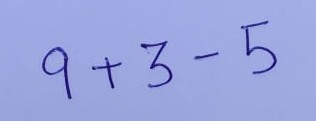

('9', 98.79574179649353)
('+', 99.32170510292053)
('3', 99.99513626098633)
('-', 99.91315007209778)
('5', 99.1050124168396)
Equation: 9 + 3 - 5 
Solution: 7


In [ ]:
img_path = "/content/test1.jpeg"
display(Image(filename=img_path)) 
patterns = extract_patterns(img_path)
eq = ''

for pattern in patterns:
    patrern_string = predict_image(pattern)
    print(patrern_string)
    eq = eq +  str(patrern_string[0]) + " "

print("Equation:", eq)
print("Solution:", eval(eq))